In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
## import libraries

import math
import matplotlib
import json
import requests
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as dates
import os

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

%matplotlib inline

In [3]:
company_name = 'AAPL'
token = "YFl1bfK9zAddFzcsOgenstMkFg3Vl84lb6rtf80vAbQ2yj1ldqM4lv75cE5q"

In [4]:
funct = "history"
sym = "AAPL"

In [5]:
url = (f"https://api.worldtradingdata.com/api/v1/history?symbol={company_name}&date_from=2015-01-01&sort=newest&api_token={token}")

In [6]:
######### Extract data from the url given ##############

#convert response to python json list
data = requests.get(url).json()[funct]

In [7]:
# Make dataframe from the json file 

df = pd.DataFrame(data)
df = df.T

In [8]:
df.tail()

,open,close,high,low,volume
2015-01-08,109.23,111.89,112.15,108.70,59364547
2015-01-07,107.20,107.75,108.20,106.70,40105934
2015-01-06,106.54,106.26,107.43,104.63,65797116
2015-01-05,108.29,106.25,108.65,105.41,64285491
2015-01-02,111.39,109.33,111.44,107.35,53204626


In [9]:
df.head()

,open,close,high,low,volume
2019-10-30,244.76,243.26,245.30,241.21,31130522
2019-10-29,248.97,243.29,249.75,242.57,35709867
2019-10-28,247.42,249.05,249.25,246.72,24143241
2019-10-25,243.16,246.58,246.73,242.88,18369296
2019-10-24,244.51,243.58,244.80,241.81,17916255


In [10]:
#convert list to dataframe with columns names and order

df = pd.DataFrame(columns=['Date','Open','High','Low','Close'])
for k,v in data.items():
    date = datetime.strptime(k, '%Y-%m-%d')
    data_row = [date.date(),float(v['open']),float(v['high']),
                float(v['low']),float(v['close'])]
    df.loc[-1,:] = data_row
    df.index = df.index + 1

In [11]:
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

In [12]:
# copy the dataframe to another dataframe

dfCopy = df.copy()

In [13]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

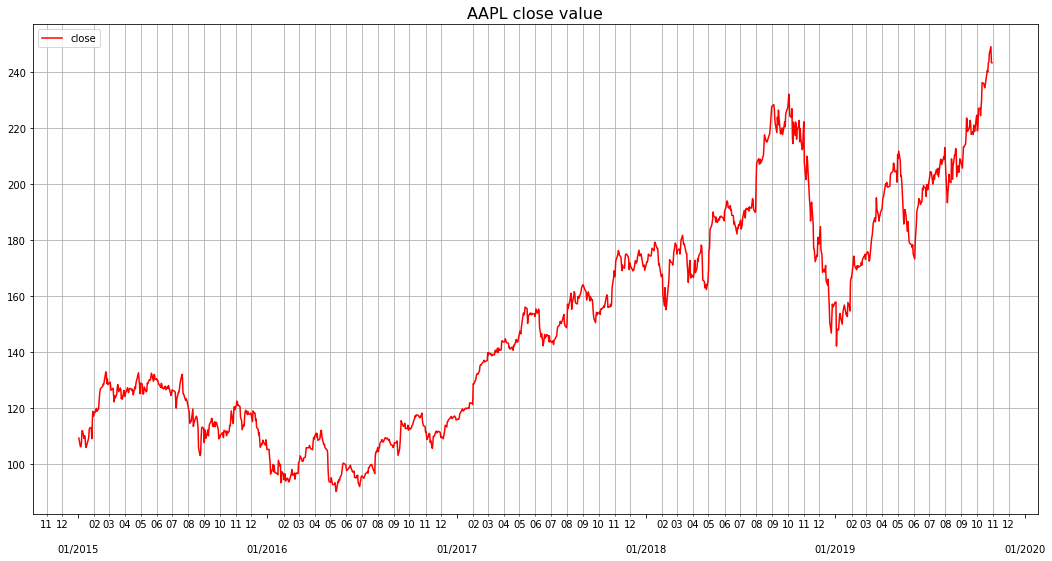

In [14]:
######### Make the plot with Close value ##########

#df = df.astype(float)
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_title(f'{sym} close value', fontdict={'fontsize': 16, 'fontweight': 'medium'})
ax.plot_date(dfCopy['Date'], dfCopy['Close'], 'r-', label='close')
#ax.plot_date(df['Date'], df['Close'], 'b-', label='CLOSE')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n%m/%Y'))
plt.legend(loc=2)
#plt.tight_layout()
plt.show()

In [15]:
dfCopy.head(2)

,Date,Open,High,Low,Close
1215,2019-10-30,244.76,245.3,241.21,243.26
1214,2019-10-29,248.97,249.75,242.57,243.29


In [16]:
# make Date as index as index 

dfCopy.index = dfCopy.Date

In [17]:
dfCopy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1216 entries, 2019-10-30 to 2015-01-02
Data columns (total 5 columns):
Date     1216 non-null datetime64[ns]
Open     1216 non-null object
High     1216 non-null object
Low      1216 non-null object
Close    1216 non-null object
dtypes: datetime64[ns](1), object(4)
memory usage: 57.0+ KB


In [18]:
# Taking only Close column with index

dfCopy = dfCopy.iloc[::-1]
df_f = dfCopy['Close']

In [19]:
df_f.shape

(1216,)

In [20]:
df_f.head(2)

Date
2015-01-02    109.33
2015-01-05    106.25
Name: Close, dtype: object

#### Handling missing value

In [21]:
### filling with missing value with spline interpolation


#df_f = df_f.resample('D')

upsampled = dfCopy['Close'].resample('D').interpolate().astype(float)
interpolated_1 = upsampled.interpolate(method='spline', order=2).astype(float)

In [22]:
df_final = pd.DataFrame(interpolated_1)
df_final.head(5)

,Close
Date,
2015-01-02,109.330000
2015-01-03,106.843276
2015-01-04,105.498112
2015-01-05,106.250000
2015-01-06,106.260000


In [23]:
########## split the dataset with train set and test set

df_t = df_final.head(1500)
df_test = df_final.tail(258)

## LSTM model

In [24]:
########## making windows with train data ##############

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [25]:
########## making windows with test data ##############

def series_to_supervised_test(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in-1, -1, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i+1)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)

    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [26]:
###### forecast lstm output with history data

def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]

In [27]:
########## generate output from lstm 

def make_forecasts(model, n_batch, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:((3*n_lag))], test[i, ((3*n_lag)):]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [28]:
###### Making shift to the dataset and calculate cumulative value, rolling mean, rolling standard deviation

train_forex_f = df_t.copy()
#train_forex_f = train_forex_f.groupby(train_forex_f.index).mean()
train_forex_f['daily_return'] = train_forex_f['Close'][:-1].values / train_forex_f['Close'][1:] - 1
train_forex_f['Cumulative'] = train_forex_f['daily_return'].cumsum()
train_forex_f['rolling_mean'] = train_forex_f['Close'].rolling(2).mean()
train_forex_f.loc[train_forex_f.index.min().strftime('%Y-%m-%d')].rolling_mean =0
train_forex_f['rolling_stddev'] = train_forex_f['Close'].rolling(2).std()
train_forex_f.loc[train_forex_f.index.min().strftime('%Y-%m-%d')].rolling_stddev=0

In [29]:
train_forex_f.head(2)

,Close,daily_return,Cumulative,rolling_mean,rolling_stddev
Date,,,,,
2015-01-02,109.330000,NaN,NaN,0.000000,0.000000
2015-01-03,106.843276,0.023275,0.023275,108.086638,1.758379


In [30]:
######## Also added day and month as the features

datadates = train_forex_f.index.values
datamonths = pd.Series(data=[pd.to_datetime(x).month for x in datadates], index=datadates, name='month')
datadays = pd.Series([pd.to_datetime(x).day for x in datadates], index=datadates, name='day')

time_1 = datamonths.to_frame().join(datadays.to_frame())


In [31]:
data_full = time_1.join(train_forex_f)

In [32]:
data_full.head()

,month,day,Close,daily_return,Cumulative,rolling_mean,rolling_stddev
2015-01-02,1,2,109.330000,NaN,NaN,0.000000,0.000000
2015-01-03,1,3,106.843276,0.023275,0.023275,108.086638,1.758379
2015-01-04,1,4,105.498112,0.012751,0.036025,106.170694,0.951174
2015-01-05,1,5,106.250000,-0.007077,0.028949,105.874056,0.531665
2015-01-06,1,6,106.260000,-0.000094,0.028854,106.255000,0.007071


In [33]:
pd.set_option('display.max_column',100)

In [34]:
data_full.head(5)

,month,day,Close,daily_return,Cumulative,rolling_mean,rolling_stddev
2015-01-02,1,2,109.330000,NaN,NaN,0.000000,0.000000
2015-01-03,1,3,106.843276,0.023275,0.023275,108.086638,1.758379
2015-01-04,1,4,105.498112,0.012751,0.036025,106.170694,0.951174
2015-01-05,1,5,106.250000,-0.007077,0.028949,105.874056,0.531665
2015-01-06,1,6,106.260000,-0.000094,0.028854,106.255000,0.007071


In [35]:
# frame as supervised learning with 10 windows value

reframed = series_to_supervised(data_full, 10, 1)
reframed.head(5)

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),var5(t-9),var6(t-9),var7(t-9),var1(t-8),var2(t-8),var3(t-8),var4(t-8),var5(t-8),var6(t-8),var7(t-8),var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
2015-01-13,1.0,3.0,106.843276,0.023275,0.023275,108.086638,1.758379,1.0,4.0,105.498112,0.012751,0.036025,106.170694,0.951174,1.0,5.0,106.25,-0.007077,0.028949,105.874056,0.531665,1.0,6.0,106.260000,-0.000094,0.028854,106.255000,0.007071,1.0,7.0,107.750000,-0.013828,0.015026,107.005000,1.053589,1.0,8.0,111.890000,-0.037001,-0.021975,109.820000,2.927422,1.0,9.0,112.010000,-0.001071,-0.023046,111.950000,0.084853,1.0,10.0,111.163075,0.007619,-0.015427,111.586537,0.598866,1.0,11.0,110.616473,0.004941,-0.010486,110.889774,0.386506,1.0,12.0,109.25,0.012508,0.002022,109.933236,0.966242,1,13,110.220000,-0.008801,-0.006779,109.735000,0.685894
2015-01-14,1.0,4.0,105.498112,0.012751,0.036025,106.170694,0.951174,1.0,5.0,106.250000,-0.007077,0.028949,105.874056,0.531665,1.0,6.0,106.26,-0.000094,0.028854,106.255000,0.007071,1.0,7.0,107.750000,-0.013828,0.015026,107.005000,1.053589,1.0,8.0,111.890000,-0.037001,-0.021975,109.820000,2.927422,1.0,9.0,112.010000,-0.001071,-0.023046,111.950000,0.084853,1.0,10.0,111.163075,0.007619,-0.015427,111.586537,0.598866,1.0,11.0,110.616473,0.004941,-0.010486,110.889774,0.386506,1.0,12.0,109.250000,0.012508,0.002022,109.933236,0.966242,1.0,13.0,110.22,-0.008801,-0.006779,109.735000,0.685894,1,14,109.800000,0.003825,-0.002953,110.010000,0.296985
2015-01-15,1.0,5.0,106.250000,-0.007077,0.028949,105.874056,0.531665,1.0,6.0,106.260000,-0.000094,0.028854,106.255000,0.007071,1.0,7.0,107.75,-0.013828,0.015026,107.005000,1.053589,1.0,8.0,111.890000,-0.037001,-0.021975,109.820000,2.927422,1.0,9.0,112.010000,-0.001071,-0.023046,111.950000,0.084853,1.0,10.0,111.163075,0.007619,-0.015427,111.586537,0.598866,1.0,11.0,110.616473,0.004941,-0.010486,110.889774,0.386506,1.0,12.0,109.250000,0.012508,0.002022,109.933236,0.966242,1.0,13.0,110.220000,-0.008801,-0.006779,109.735000,0.685894,1.0,14.0,109.80,0.003825,-0.002953,110.010000,0.296985,1,15,106.820000,0.027897,0.024944,108.310000,2.107178
2015-01-16,1.0,6.0,106.260000,-0.000094,0.028854,106.255000,0.007071,1.0,7.0,107.750000,-0.013828,0.015026,107.005000,1.053589,1.0,8.0,111.89,-0.037001,-0.021975,109.820000,2.927422,1.0,9.0,112.010000,-0.001071,-0.023046,111.950000,0.084853,1.0,10.0,111.163075,0.007619,-0.015427,111.586537,0.598866,1.0,11.0,110.616473,0.004941,-0.010486,110.889774,0.386506,1.0,12.0,109.250000,0.012508,0.002022,109.933236,0.966242,1.0,13.0,110.220000,-0.008801,-0.006779,109.735000,0.685894,1.0,14.0,109.800000,0.003825,-0.002953,110.010000,0.296985,1.0,15.0,106.82,0.027897,0.024944,108.310000,2.107178,1,16,105.990000,0.007831,0.032775,106.405000,0.586899
2015-01-17,1.0,7.0,107.750000,-0.013828,0.015026,107.005000,1.053589,1.0,8.0,111.890000,-0.037001,-0.021975,109.820000,2.927422,1.0,9.0,112.01,-0.001071,-0.023046,111.950000,0.084853,1.0,10.0,111.163075,0.007619,-0.015427,111.586537,0.598866,1.0,11.0,110.616473,0.004941,-0.010486,110.889774,0.386506,1.0,12.0,109.250000,0.012508,0.002022,109.933236,0.966242,1.0,13.0,110.220000,-0.008801,-0.006779,109.735000,0.685894,1.0,14.0,109.800000,0.003825,-0.002953,110.010000,0.296985,1.0,15.0,106.820000,0.027897,0.024944,108.310000,2.107178,1.0,16.0,105.99,0.007831,0.032775,106.405000,0.586899,1,17,106.378743,-0.003654,0.029121,106.184371,0.274883


In [36]:
list(range(len(reframed.columns))[-7:])

[70, 71, 72, 73, 74, 75, 76]

In [37]:
# drop columns we don't want to predict (ie month, day, xb2 on day t) (except the Close price column)
reframed.drop(reframed.columns[[70, 71, 73, 74, 75, 76]], axis=1, inplace=True)

In [38]:
reframed.columns.shape

(71,)

In [39]:
######## Normalise the data ############

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)
values = scaled

In [40]:
reframed.head(1)

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),var5(t-9),var6(t-9),var7(t-9),var1(t-8),var2(t-8),var3(t-8),var4(t-8),var5(t-8),var6(t-8),var7(t-8),var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var3(t)
2015-01-13,1.0,3.0,106.843276,0.023275,0.023275,108.086638,1.758379,1.0,4.0,105.498112,0.012751,0.036025,106.170694,0.951174,1.0,5.0,106.25,-0.007077,0.028949,105.874056,0.531665,1.0,6.0,106.26,-0.000094,0.028854,106.255,0.007071,1.0,7.0,107.75,-0.013828,0.015026,107.005,1.053589,1.0,8.0,111.89,-0.037001,-0.021975,109.82,2.927422,1.0,9.0,112.01,-0.001071,-0.023046,111.95,0.084853,1.0,10.0,111.163075,0.007619,-0.015427,111.586537,0.598866,1.0,11.0,110.616473,0.004941,-0.010486,110.889774,0.386506,1.0,12.0,109.25,0.012508,0.002022,109.933236,0.966242,110.22


In [41]:
reframed.shape

(1489, 71)

In [42]:
##### spliting the data to training and validation for lstm model

n_train_days = 1200
train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [43]:
# split into input and outputs
train_X_1, train_y_1 = train[:, :-1], train[:, -1]
test_X_1, test_y_1 = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X_1.reshape((train_X_1.shape[0], 1, train_X_1.shape[1]))
test_X = test_X_1.reshape((test_X_1.shape[0], 1, test_X_1.shape[1]))

In [44]:
import tensorflow as tf
import keras
import numpy as np

tf.__version__

Using TensorFlow backend.


'2.0.0'

In [45]:
# design LSTM network
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(70, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')

In [46]:
# fit network with 10 epochs

history = model.fit(train_X, train_y_1, epochs=10, validation_data=(test_X, test_y_1), verbose=2,shuffle=False)
## make a prediction
yhat = model.predict(test_X)
print(len(yhat))

Train on 1200 samples, validate on 289 samples
Epoch 1/10
1200/1200 - 3s - loss: 0.1427 - val_loss: 0.1397
Epoch 2/10
1200/1200 - 0s - loss: 0.2682 - val_loss: 0.2117
Epoch 3/10
1200/1200 - 0s - loss: 0.0640 - val_loss: 0.0687
Epoch 4/10
1200/1200 - 0s - loss: 0.0570 - val_loss: 0.0691
Epoch 5/10
1200/1200 - 0s - loss: 0.1474 - val_loss: 0.1378
Epoch 6/10
1200/1200 - 0s - loss: 0.0434 - val_loss: 0.0751
Epoch 7/10
1200/1200 - 0s - loss: 0.0240 - val_loss: 0.0662
Epoch 8/10
1200/1200 - 0s - loss: 0.0691 - val_loss: 0.0630
Epoch 9/10
1200/1200 - 0s - loss: 0.0945 - val_loss: 0.0547
Epoch 10/10
1200/1200 - 0s - loss: 0.0310 - val_loss: 0.0658
289


In [47]:
print(test_X.shape)
test_X_2 = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_X_2.shape

(289, 1, 70)


(289, 70)

In [48]:
# invert scaling for forecast
inv_yhat = np.concatenate((test_X_2[:, 0:], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, -1]

In [49]:
# invert scaling for actual
test_y = test_y_1.reshape((len(test_y_1), 1))
inv_y = np.concatenate((test_X_2[:, 0:], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1]

In [50]:
import matplotlib.pyplot as plt

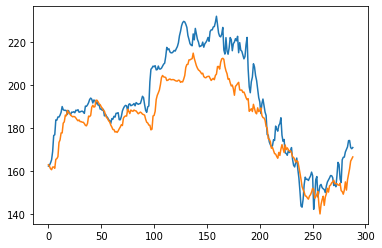

In [51]:

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
plt.figure()
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

In [64]:
print('validation set rmse : ',rmse)

validation set rmse :  11.737441468048953


In [52]:
def make_forecasts(model, n_batch, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:((3*n_lag))], test[i, ((3*n_lag)):]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [53]:
df_test.head()

,Close
Date,
2019-02-15,170.420000
2019-02-16,170.653447
2019-02-17,170.960863
2019-02-18,171.272740
2019-02-19,170.930000


In [54]:
df_dict = {}

In [55]:
data_test = df_test.tail(110).head(10)
test_data_2 = data_test.copy()
test_data_2.head()

,Close
Date,
2019-07-13,204.584099
2019-07-14,204.830835
2019-07-15,205.210000
2019-07-16,204.500000
2019-07-17,203.350000


In [56]:
test_data_2.reset_index(drop=False,inplace=True)
test_data_2.head(1)

,Date,Close
0,2019-07-13,204.584099


In [57]:
from tqdm import tqdm_notebook as tqdm 
import warnings 
warnings.filterwarnings('ignore')

In [58]:
for i in tqdm(range(100)):
    
    test_data_2.reset_index(drop=True,inplace=True)
    test_data_2['Date'] = pd.to_datetime(test_data_2['Date'])
    
    intial_time = str(test_data_2.Date.iloc[0])
    test_data_2.index = test_data_2.Date
    test_data_2.drop(['Date'],axis=1,inplace=True)

    test_data_2 = test_data_2.fillna(method='ffill')
    test_data_2 = test_data_2.fillna(method='bfill')
    test_data_2['daily_return'] = test_data_2['Close'][:-1].values / test_data_2['Close'][1:] - 1
    test_data_2['Cumulative'] = test_data_2['daily_return'].cumsum()
    test_data_2['rolling_mean'] = test_data_2['Close'].rolling(2).mean()
    test_data_2['rolling_stddev'] = test_data_2['Close'].rolling(2).std()
    test_data_2.loc[intial_time].rolling_mean =0
    test_data_2.loc[intial_time].rolling_stddev=0
    test_data_2.loc[intial_time].daily_return=0
    test_data_2.loc[intial_time].Cumulative=0

    datadates = test_data_2.index.values
    datamonths = pd.Series(data=[pd.to_datetime(x).month for x in datadates], index=datadates, name='month')
    datadays = pd.Series([pd.to_datetime(x).day for x in datadates], index=datadates, name='day')
    
    time_1 = datamonths.to_frame().join(datadays.to_frame())
    
    test_data_full = time_1.join(test_data_2)
    reframed_2 = series_to_supervised_test(test_data_full, 10, 0)

    #print(reframed_2)
    #reframed_2.drop(reframed_2.columns[[21,22,24,25,26,27]], axis=1, inplace=True)
    reframed_2 = reframed.loc[:, reframed.columns != 'var3(t)'].append(reframed_2)
    #print(reframed_2)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_2 = scaler.fit_transform(reframed_2)
    #print(scaled_2)
    scaled_2 = scaled_2[-1:,:]
    scaled_3 = scaled_2[:,:-1]
    forecasts = make_forecasts(model, 1, scaled_2, 30, 8)

    #print(forecasts)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(reframed)
    inv_yhat_2 = np.concatenate((scaled_2, forecasts), axis=1)
    inv_yhat_2 = scaler.inverse_transform(inv_yhat_2)
    inv_yhat_2 = inv_yhat_2[:, -1]

    #act_val =test_data_2['Price'].values
    #next_minute = datetime.date(datetime.now()+timedelta(days=1))
    test_data_2.drop(['daily_return','Cumulative','rolling_mean','rolling_stddev'],axis=1,inplace=True)
    test_data_2 = test_data_2.tail(9)
    test_data_2 = test_data_2.reset_index()
    next_minute = test_data_2.tail(1).Date + timedelta(days=1)
    next_value = inv_yhat_2[0]

    df_dict[next_minute.values[0]] = next_value
    
    test_data_2.loc[9] = [next_minute.values[0],next_value]
    #print(str(next_minute.values[0]),' : ', next_value)

In [59]:
len(list(df_dict.values()))

100

In [60]:
import matplotlib.pyplot as plt

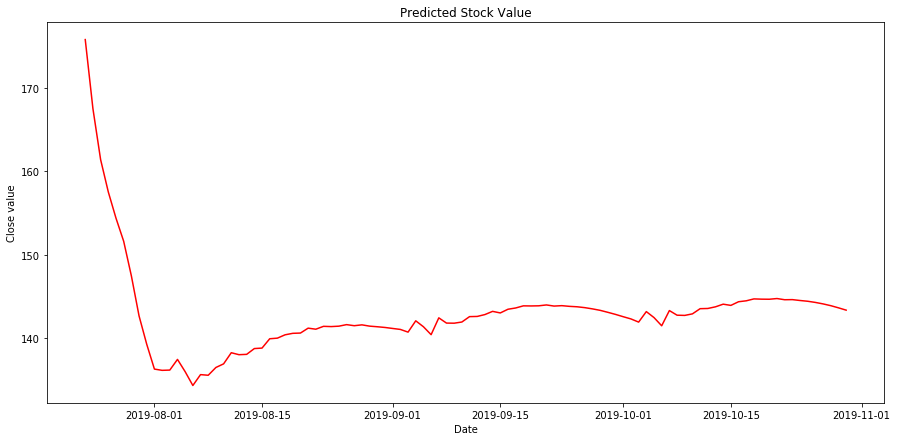

In [78]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot_date(df_test.tail(100).index,list(df_dict.values()),'r-',label='predited')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
ax.xaxis.grid(True, which="minor")
plt.title('Predicted Stock Value with LSTM model')
plt.xlabel('Date')
plt.ylabel('Close value')
plt.show()

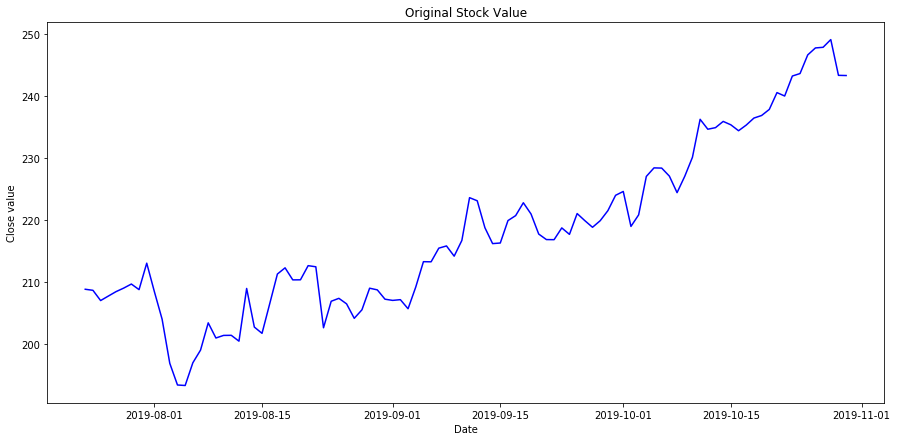

In [79]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot_date(df_test.tail(100).index,df_test.tail(100)['Close'],'r-',label='original',color='blue')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
ax.xaxis.grid(True, which="minor")

plt.title('Original Stock Value')
plt.xlabel('Date')
plt.ylabel('Close value')

plt.show()

In [111]:
print('RMSE test value with LSTM: ',mean_squared_error(df_test.tail(100)['Close'].values.tolist(),list(df_dict.values())))

RMSE test value with LSTM:  5818.542114685997


## Using Prophet library

In [87]:
df_pr = df_t.copy()

In [88]:
### make dataframe with respect to Prophet

df_pr['ds'] = df_pr.index
#log transform the ‘Close’ variable to convert non-stationary data to stationary.
df_pr['y'] = (df_pr['Close'])

In [89]:
df_pr.head()

,Close,ds,y
Date,,,
2015-01-02,109.330000,2015-01-02,109.330000
2015-01-03,106.843276,2015-01-03,106.843276
2015-01-04,105.498112,2015-01-04,105.498112
2015-01-05,106.250000,2015-01-05,106.250000
2015-01-06,106.260000,2015-01-06,106.260000


In [90]:
df_pr.reset_index(inplace=True,drop=True)
df_pr.drop(['Close'],axis=1,inplace=True)

In [91]:
df_pr.head(2)

,ds,y
0,2015-01-02,109.330000
1,2015-01-03,106.843276


In [92]:
##### Importing library

from fbprophet import Prophet

In [93]:
df_pr.shape

(1500, 2)

In [94]:
# Making with daily seasonaly True

model = Prophet(daily_seasonality=True)
model.fit(df_pr)

In [95]:
df_test.shape

(258, 1)

In [96]:
df_test.head()

,Close
Date,
2019-02-15,170.420000
2019-02-16,170.653447
2019-02-17,170.960863
2019-02-18,171.272740
2019-02-19,170.930000


In [97]:
####### Making prediction for next 100 days

num_days = df_test.shape[0]
    
future = model.make_future_dataframe(periods=num_days)
forecast = model.predict(future)

print (forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds        yhat  yhat_lower  yhat_upper
1753 2019-10-21  197.567416   97.177234  291.137344
1754 2019-10-22  197.468550   96.255620  288.891903
1755 2019-10-23  197.440945   97.055698  291.628855
1756 2019-10-24  197.084561   94.925365  291.621524
1757 2019-10-25  196.629950   93.510215  290.188984


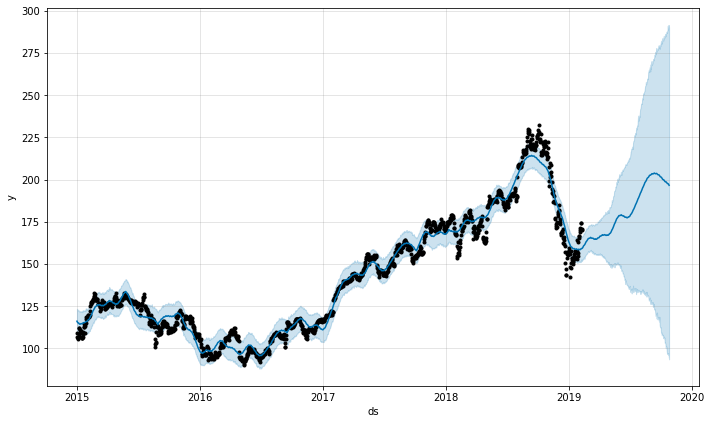

In [98]:
####### Plot with variation of prediction(with upper limit and lower limit)

forecast_plot = model.plot(forecast)
forecast_plot.show()

In [99]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,112.626375,108.651629,123.551374,112.626375,112.626375,3.497880,3.497880,3.497880,24.501276,24.501276,24.501276,-0.074539,-0.074539,-0.074539,-20.928857,-20.928857,-20.928857,0.0,0.0,0.0,116.124256
1,2015-01-03,112.720572,108.760629,123.267173,112.720572,112.720572,3.026032,3.026032,3.026032,24.501276,24.501276,24.501276,-0.091087,-0.091087,-0.091087,-21.384156,-21.384156,-21.384156,0.0,0.0,0.0,115.746605
2,2015-01-04,112.814769,108.388309,122.642078,112.814769,112.814769,2.541709,2.541709,2.541709,24.501276,24.501276,24.501276,-0.164828,-0.164828,-0.164828,-21.794740,-21.794740,-21.794740,0.0,0.0,0.0,115.356478
3,2015-01-05,112.908966,107.675139,122.437579,112.908966,112.908966,2.282019,2.282019,2.282019,24.501276,24.501276,24.501276,-0.058603,-0.058603,-0.058603,-22.160655,-22.160655,-22.160655,0.0,0.0,0.0,115.190985
4,2015-01-06,113.003164,108.074896,122.937112,113.003164,113.003164,2.060582,2.060582,2.060582,24.501276,24.501276,24.501276,0.041936,0.041936,0.041936,-22.482630,-22.482630,-22.482630,0.0,0.0,0.0,115.063746


In [100]:
forecast.iloc[1500:]['yhat']

1500    159.465060
1501    159.816826
1502    160.186754
1503    160.667999
1504    160.861572
           ...    
1753    197.567416
1754    197.468550
1755    197.440945
1756    197.084561
1757    196.629950
Name: yhat, Length: 258, dtype: float64

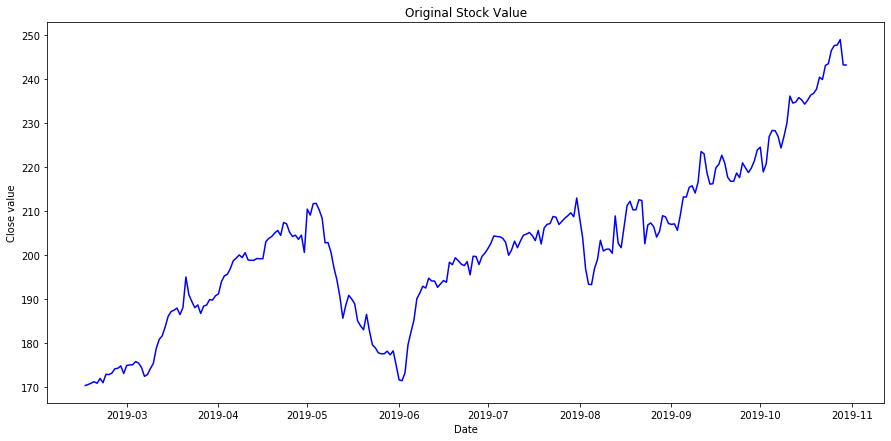

In [109]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot_date(df_test.index,df_test['Close'],'r-',label='original',color='blue')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
ax.xaxis.grid(True, which="minor")

plt.title('Original Stock Value')
plt.xlabel('Date')
plt.ylabel('Close value')

plt.show()


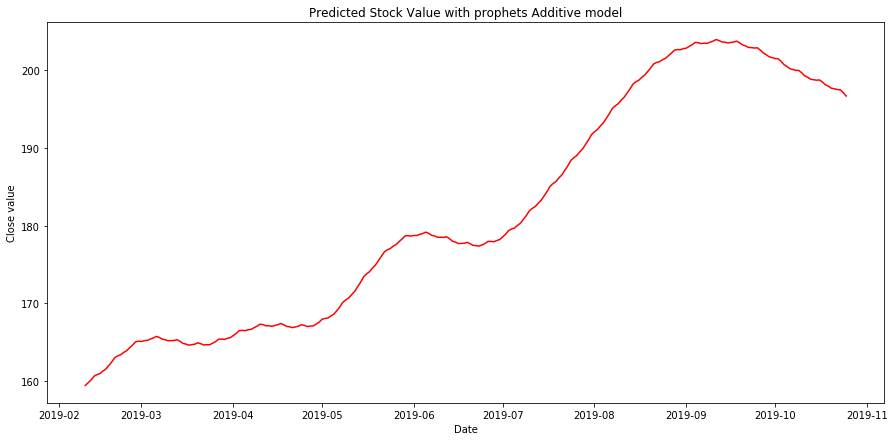

In [106]:
##plt.plot(list(range(258)),forecast.iloc[1500:]['yhat'],label='predicted')
#plt.show()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot_date(forecast.iloc[1500:]['ds'],forecast.iloc[1500:]['yhat'],'r-',label='predited')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
ax.xaxis.grid(True, which="minor")
plt.title('Predicted Stock Value with prophets Additive model')
plt.xlabel('Date')
plt.ylabel('Close value')
plt.show()

In [110]:
print('RMSE value on test set with Prophet : ',mean_squared_error(df_test['Close'],forecast.iloc[1500:]['yhat']))

RMSE value on test set with Prophet :  552.9824255758182


## Arima

In [112]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [113]:
## making arima model with history data

history = df_t['Close'].values.tolist()
test = df_test['Close'].values.tolist()
predictions = list()


for t in tqdm(range((df_test.shape[0]))):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)

In [116]:
print('RMSE value on test set with Arima model : ',error)

RMSE value on test set with Arima model :  886.35543451713


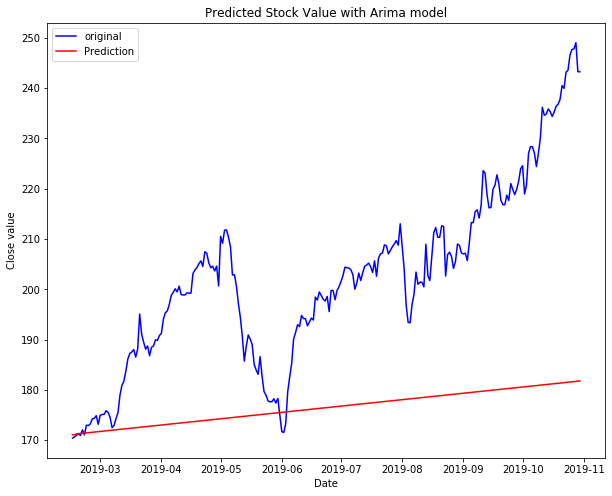

In [120]:
#plt.plot(list(range(258)),test,label='original')
#plt.plot(list(range(258)),predictions,label='prediction')

plt.figure(figsize=(10,8))
plt.plot_date(df_test.index,test,'r-',label='original',color='blue')
plt.plot_date(df_test.index,predictions,'r-',label='Prediction',color='red')
plt.title('Predicted Stock Value with Arima model')
plt.xlabel('Date')
plt.ylabel('Close value')
ax.xaxis.set_minor_locator(dates.MonthLocator())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%m'))
plt.legend()
plt.show()

#### Reference 

* https://facebook.github.io/prophet/docs/quick_start.html
* https://research.fb.com/prophet-forecasting-at-scale/
* https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average
* https://www.statsmodels.org/
* https://www.tensorflow.org/tutorials/structured_data/time_series
